In [1]:
! pip install langchain==0.3.8 langchain-openai==0.2.0 langchain-anthropic==0.2.1 langchain-nomic==0.1.3 langchain-fireworks==0.2.0 langchain-community==0.3.0 langchain-experimental==0.3.2 langgraph-checkpoint-mongodb==0.1.0

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import os
import json
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = json.load(open('keys.json', 'r'))['smith_api_key']

### 客户支持机器人
客户支持机器人可以通过处理日常问题来释放团队的时间，但要构建一个能够可靠处理多样化任务且不让用户抓狂的机器人可能并不容易。

在本教程中，您将为一个航空公司构建一个客户支持机器人，帮助用户研究和安排旅行。您将学习如何使用 LangGraph 的中断和检查点功能，以及更复杂的状态管理来组织助手的工具，并管理用户的航班预订、酒店预订、租车和短途旅行。本教程假设您已经熟悉 LangGraph 入门教程中介绍的概念。

到教程结束时，您将构建一个可工作的机器人，并理解 LangGraph 的关键概念和架构。您将能够将这些设计模式应用到其他 AI 项目中。

您最终的聊天机器人将类似于下图所示：

![image.png](imgs/part-4-diagram.png)

让我们开始吧！



### 前提条件

首先，设置您的环境。我们将安装本教程所需的依赖项，下载测试数据库，并定义在每个部分中会重复使用的工具。

我们将使用 qwen 作为我们的 LLM（大语言模型），并定义一些自定义工具。虽然大多数工具将连接到本地的 SQLite 数据库（无需额外依赖项），但我们还将使用 Tavily 为代理提供通用的网络搜索功能。

#### 填充数据库

运行以下脚本以获取我们为本教程准备的 SQLite 数据库，并将其更新为当前状态。具体细节并不重要。

In [3]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)


# Convert the flights to present time for our tutorial
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_file)

### 工具
接下来，定义我们助手的工具，用于搜索航空公司的政策手册，以及搜索和管理航班、酒店、租车和短途旅行的预订。我们将在整个教程中重复使用这些工具。具体的实现并不重要，因此请随意运行下面的代码并跳转到第1部分。

#### 查找公司政策
助手可以检索政策信息以回答用户的问题。请注意，这些政策的执行仍然必须在工具/API内部完成，因为LLM（大语言模型）可能会忽略这些信息。

In [4]:
import re
import requests
from openai import OpenAI
import numpy as np
import openai
from langchain_core.tools import tool
import json
response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = client

    @classmethod
    def from_docs(cls, docs, client):
        embeddings = client.embeddings.create(
            model="text-embedding-v3", input=[doc["page_content"] for doc in docs], dimensions=1024,encoding_format="float"
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-v3", input=[query], dimensions=1024,encoding_format="float"
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]

client = OpenAI(
    api_key=json.load(open('keys.json', 'r'))['qwen_api_key'],  # 如果您没有配置环境变量，请在此处用您的API Key进行替换
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"  # 百炼服务的base_url
)
retriever = VectorStoreRetriever.from_docs(docs, client)


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

retriever._arr

array([[-0.05252242,  0.0263174 , -0.01230643, ..., -0.01112636,
         0.0143575 , -0.00343718],
       [-0.03355714,  0.03567319, -0.0467403 , ..., -0.02408174,
         0.0467403 , -0.02848237],
       [-0.04809149,  0.0271896 , -0.06840272, ..., -0.0375167 ,
         0.03555417,  0.00183034],
       ...,
       [-0.04062159,  0.03284299, -0.07169843, ..., -0.04114768,
         0.01095393, -0.01907073],
       [-0.04209022,  0.00417947, -0.04937213, ...,  0.01389663,
         0.00292134,  0.00486096],
       [-0.06762026,  0.03998609, -0.03527529, ..., -0.03477454,
        -0.00663035,  0.00911093]])

#### 航班
定义 `fetch_user_flight_information` 工具，以便代理查看当前用户的航班信息。然后定义工具来搜索航班并管理存储在 SQL 数据库中的乘客预订信息。  

我们可以访问给定运行的 `RunnableConfig`，以检查访问此应用程序的用户的 `passenger_id`。LLM 无需显式提供这些信息，它们会在每次调用图时自动提供，以确保每个用户无法访问其他乘客的预订信息。

In [5]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig


@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT 
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM 
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE 
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id: int, *, config: RunnableConfig
) -> str:
    """Update the user's ticket to a new valid flight."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """Cancel the user's ticket and remove it from the database."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

#### 汽车租赁工具  
当用户预订航班后，他们可能还需要安排交通工具。定义一些“汽车租赁”工具，以便用户搜索并在目的地预订汽车。

In [6]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

#### 酒店
用户需要住宿！定义一些工具来搜索并管理酒店预订。

In [7]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

#### 游览活动
最后，定义一些工具，让用户搜索到达目的地后可以进行的活动（并完成预订）。

In [8]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book a excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

#### 实用工具
定义一些辅助函数，以便在调试时美化图中的消息输出，并为工具节点添加错误处理功能（通过将错误添加到聊天记录中）。

In [9]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

### 第一部分：零样本代理（Zero-shot Agent）
在构建时，最好从最简单的可用实现开始。在其他条件相同的情况下，优先选择简单且可扩展的解决方案，而不是复杂的方案。在这种情况下，单图方法存在一些局限性。例如，机器人可能会在未经用户确认的情况下执行不需要的操作，难以处理复杂查询，并且响应缺乏重点。我们将在后续部分解决这些问题。

在本节中，我们将定义一个简单的零样本代理作为助手，为该代理提供所有工具，并提示它谨慎使用这些工具来帮助用户。

这个简单的 2 节点图如下所示：
![image.png](./imgs/part-1-diagram.png)

首先，我们需要定义状态。

#### State
将我们的 `StateGraph` 的状态定义为一个类型化的字典，其中包含一个仅可追加的消息列表。这些消息构成了聊天历史记录，这是我们简单助手所需的全部状态。


In [10]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

#### Agent
接下来，定义助手函数。该函数接收图状态，将其格式化为提示，然后调用 LLM 以预测最佳响应。

In [11]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=json.load(open('keys.json', 'r'))['qwen_api_key'],
    model="qwen-turbo-1101",
)

# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)
os.environ["TAVILY_API_KEY"] = json.load(open('keys.json', 'r'))['tavily_api_key']
tavilySearch = TavilySearchResults(max_results=1)
part_1_tools = [
    tavilySearch,
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

#### 定义图
现在，创建图。该图是本部分的最终助手。

In [12]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

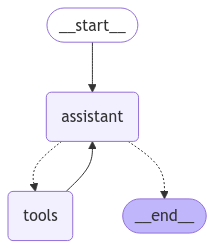

In [16]:
from IPython.display import Image, display

display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))

#### 示例对话
现在是时候试试我们强大的聊天机器人了！让我们在以下对话轮次中运行它。如果遇到“递归限制”（RecursionLimit），这意味着代理无法在分配的步骤内获得答案。没关系！在本教程的后续部分中，我们还有更多技巧可以解决这个问题。

In [45]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    # "Am i allowed to update my flight to something sooner? I want to leave later today.",
    # "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

import sys
_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
        sys.stdout.flush() 

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

To help you with that, I will need your flight details or ticket number. Could you please provide me with that information?


#### 第一部分回顾 
我们的简单助手表现还不错！它能够对所有问题做出合理的响应，快速在上下文中回应，并成功执行所有任务。

如果这是一个简单的问答机器人，我们可能会对上述结果感到满意。但由于我们的客户支持机器人是代表用户执行操作，它的一些行为有点令人担忧：

1. 当我们在关注住宿时，助手却预订了一辆车，然后不得不取消并重新预订：哎呀！为了避免不必要的费用，用户应该在预订前有最终决定权。
2. 助手在搜索推荐时遇到了困难。我们可以通过为工具添加更详细的说明和示例来改进这一点，但为每个工具都这样做可能会导致提示过大，使代理不堪重负。
3. 助手必须进行显式搜索才能获取用户的相关信息。我们可以通过立即获取用户的相关旅行详细信息来节省大量时间，以便助手可以直接响应。

在下一部分中，我们将解决前两个问题。

### 第二部分：添加确认
当助手代表用户执行操作时，用户（几乎）应该始终对是否执行这些操作拥有最终决定权。否则，助手的任何小错误（或它遭受的任何提示注入）都可能对用户造成实际损害。

在本节中，我们将使用 `interrupt_before` 在执行任何工具之前暂停图并将控制权返回给用户。

你的图将类似于以下结构：

![image.png](./imgs/part-2-diagram.png)

和之前一样，首先定义状态：

#### 状态与助手
我们的图状态和 LLM 调用与第一部分几乎相同，除了以下例外：

1. 我们添加了一个 `user_info` 字段，该字段将由我们的图主动填充。
2. 我们可以直接在助手对象中使用状态，而不是使用可配置的参数。

In [43]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=json.load(open('keys.json', 'r'))['qwen_api_key'],
    model="qwen-turbo-1101",
)
# You could also use OpenAI or another model, though you will likely have
# to adapt the prompts
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

os.environ["TAVILY_API_KEY"] = json.load(open('keys.json', 'r'))['tavily_api_key']
tavilySearch = TavilySearchResults(max_results=1)
part_2_tools = [
    tavilySearch,
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

#### 定义图
现在，创建图。与第一部分相比，进行以下两项更改以解决我们之前的问题：

1. 在使用工具之前添加中断（`interrupt`）。
2. 在第一个节点中显式填充用户状态，以便助手无需使用工具即可了解用户信息。

In [48]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    print("fetch_user_flight_information...")
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_2_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_2_tools))
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
part_2_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["tools"],
)

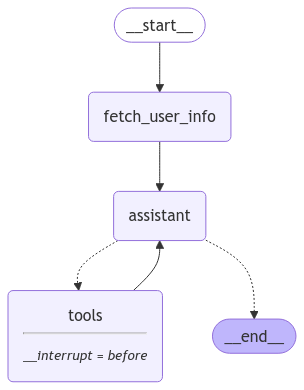

In [29]:
from IPython.display import Image, display

display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))

#### 示例对话
现在是时候试试我们新改进的聊天机器人了！让我们在以下对话轮次中运行它。


In [49]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

import sys
_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    # "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
        sys.stdout.flush() 
    # for event in events:
    #     pass  # 不打印事件，但仍然触发流式处理
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
            print("="*35, "messages", "="*35)
            for i in result["messages"]:
                print(type(i), i)
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
fetch_user_flight_information...
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_ca2fd353182146d1b6b27d)
 Call ID: call_ca2fd353182146d1b6b27d
  Args:
=================================== messages ===================================
<class 'langchain_core.messages.human.HumanMessage'> content='Hi there, what time is my flight?' additional_kwargs={} response_metadata={} id='24b89525-5098-4571-9e4a-b00783ee5187'
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'id': 'call_ca2fd353182146d1b6b27d', 'function': {'arguments': '{}', 'name': 'fetch_user_flight_information'}, 'type': 'function', 'index': 0}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 3022, 'total_tokens': 3036, 'completion_tokens_details':

#### 第二部分回顾
现在，我们的助手能够节省一步直接响应我们的航班详细信息。我们还完全控制了执行哪些操作。中断会暂停图的执行，其状态通过配置的检查点安全保存。用户可以在任何时候通过使用正确的配置运行图来重新启动它。

这个图运行得相当不错！不过，我们并不需要参与助手的每一个操作……

在下一部分中，我们将重新组织图，以便仅在“敏感”操作（即实际写入数据库的操作）时中断。

### 第三部分：条件中断
在本节中，我们将通过将工具分类为安全（只读）和敏感（数据修改）来优化中断策略。我们仅对敏感工具应用中断，允许机器人自主处理简单查询。

这种策略在用户控制和对话流畅性之间取得了平衡，但随着我们添加更多工具，单一图可能会变得过于复杂，无法适应这种“扁平”结构。我们将在下一部分中解决这个问题。

你的第三部分的图将类似于以下结构：

![image.png](./imgs/part-3-diagram.png)

#### 状态
和往常一样，首先定义图状态。我们的状态和 LLM 调用与第二部分完全相同。


In [54]:
from typing import Annotated
import json
import os
from datetime import date, datetime
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=json.load(open('keys.json', 'r'))['qwen_api_key'],
    model="qwen-turbo-1101",
)

# You can update the LLMs, though you may need to update the prompts
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)


# "Read"-only tools (such as retrievers) don't need a user confirmation to use
os.environ["TAVILY_API_KEY"] = json.load(open('keys.json', 'r'))['tavily_api_key']
tavilySearch = TavilySearchResults(max_results=1)
part_3_safe_tools = [
    tavilySearch,
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    book_hotel,
    update_hotel,
    cancel_hotel,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

#### 定义图
现在，创建图。我们的图与第二部分几乎相同，只是我们将工具拆分为两个独立的节点。我们仅在那些实际对用户预订进行更改的工具之前中断。


In [55]:
from typing import Literal
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant", route_tools, ["safe_tools", "sensitive_tools", END]
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = MemorySaver()
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

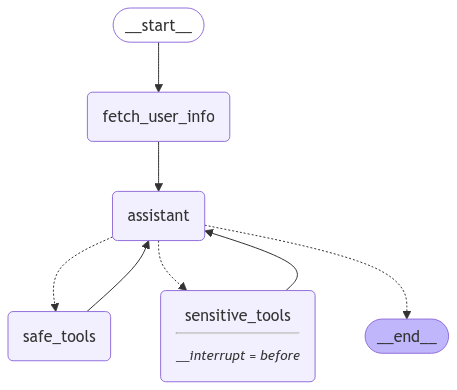

In [45]:
from IPython.display import Image, display

display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))

#### 示例对话
现在是时候试试我们新改进的聊天机器人了！让我们在以下对话轮次中运行它。这一次，我们将大大减少确认次数。


In [56]:
import shutil
import uuid
import sys

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
        sys.stdout.flush()
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
            print("="*35, "messages", "="*35)
            for i in result["messages"]:
                print(type(i), i)
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_9e0ea1f81bdb4accb6ffbf)
 Call ID: call_9e0ea1f81bdb4accb6ffbf
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-01-13 23:21:13.694473-04:00", "scheduled_arrival": "2025-01-14 00:51:13.694473-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your scheduled flight is LX0112 from CDG to BSL. It is scheduled to depart at 23:21 and arrive at 00:51 local time. Please make sure to arrive at the airport in adv

#### 第三部分回顾
好多了！我们的代理现在运行良好——查看我们最新运行的 LangSmith 跟踪以检查其工作！你可能会对这个设计感到满意。代码简洁，行为符合预期。

这种设计的一个问题是，我们对单个提示施加了很大的压力。如果我们想添加更多工具，或者每个工具变得更复杂（更多过滤器、更多约束行为的业务逻辑等），工具的使用和机器人的整体行为可能会开始受到影响。

在下一部分中，我们将展示如何通过根据用户意图路由到专门的代理或子图来更好地控制不同的用户体验。

### 第四部分：专用工作流
在前几部分中，我们看到依赖单一提示和 LLM 来处理各种用户意图的“宽泛”聊天机器人可以带我们走得很远。然而，这种方法很难为已知意图创建可预测的优秀用户体验。

不妨换个思路，让你的图可以检测用户意图并选择适当的工作流或“技能”来满足用户需求。每个工作流都可以专注于其领域，从而在不降低整体助手性能的情况下进行独立改进。

在本节中，我们将用户体验拆分为单独的子图，形成如下结构：

![image.png](./imgs/part-4-diagram.png)

在上图中，每个方块代表一个代理化的、专注的工作流。主助手处理用户的初始查询，图根据查询内容路由到适当的“专家”。

#### 状态
我们希望在任何给定时刻跟踪哪个子图处于控制状态。虽然我们可以通过对消息列表进行一些算术来实现这一点，但将其作为专用堆栈跟踪更容易。

在下面的状态中添加一个 `dialog_state` 列表。每当一个节点运行并返回 `dialog_state` 的值时，将调用 `update_dialog_stack` 函数来确定如何应用更新。

In [10]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_car_rental",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

#### 助手
这次我们将为每个工作流创建一个助手。这意味着：

1. **航班预订助手**
2. **酒店预订助手**
3. **租车助手**
4. **游览活动助手**
5. **最后，一个“主助手”用于在这些助手之间进行路由**

如果你仔细观察，可能会发现这是我们从多代理示例中提到的**监督者设计模式**的一个实例。

下面，定义用于支持每个助手的 `Runnable` 对象。每个 `Runnable` 都有一个提示、LLM 和限定于该助手的工具模式。每个专门的/委派的助手还可以调用 `CompleteOrEscalate` 工具，以指示控制流应传递回主助手。如果它已成功完成其工作，或者用户改变了主意或需要超出该特定工作流范围的帮助，就会发生这种情况。

In [11]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from datetime import datetime
from pydantic import BaseModel, Field


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True # 并不是指“取消任务”的字面意思，而是指“结束当前子任务并交还控制权”。
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True, 
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }

# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.
# The task delegation is a simple form of semantic routing / does simple intent detection
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=json.load(open('keys.json', 'r'))['qwen_api_key'],
    model="qwen-max",
)

# Flight booking assistant

flight_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling flight updates. "
            " The primary assistant delegates work to you whenever the user needs help updating their bookings. "
            "Confirm the updated flight details with the customer and inform them of any additional fees. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

update_flight_safe_tools = [search_flights]
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    update_flight_tools + [CompleteOrEscalate]
)

# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling hotel bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a hotel. "
            "Search for available hotels based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Hotel booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_hotel_safe_tools = [search_hotels]
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    book_hotel_tools + [CompleteOrEscalate]
)

# Car Rental Assistant
book_car_rental_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling car rental bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a car rental. "
            "Search for available car rentals based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_car_rental_safe_tools = [search_car_rentals]
book_car_rental_sensitive_tools = [
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
]
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    book_car_rental_tools + [CompleteOrEscalate]
)

# Excursion Assistant

book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling trip recommendations. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Excursion booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_excursion_safe_tools = [search_trip_recommendations]
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    book_excursion_tools + [CompleteOrEscalate]
)


# Primary Assistant
class ToFlightBookingAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle flight updates and cancellations."""

    request: str = Field(
        description="Any necessary followup questions the update flight assistant should clarify before proceeding."
    )


class ToBookCarRental(BaseModel):
    """Transfers work to a specialized assistant to handle car rental bookings."""

    location: str = Field(
        description="The location where the user wants to rent a car."
    )
    start_date: str = Field(description="The start date of the car rental.")
    end_date: str = Field(description="The end date of the car rental.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the car rental."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Basel",
                "start_date": "2023-07-01",
                "end_date": "2023-07-05",
                "request": "I need a compact car with automatic transmission.",
            }
        }


class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(description="The check-in date for the hotel.")
    checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Zurich",
                "checkin_date": "2023-08-15",
                "checkout_date": "2023-08-20",
                "request": "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfers work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description="The location where the user wants to book a recommended trip."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip recommendation."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Lucerne",
                "request": "The user is interested in outdoor activities and scenic views.",
            }
        }


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            "Your primary role is to search for flight information and company policies to answer customer queries. "
            "If a customer requests to update or cancel a flight, book a car rental, book a hotel, or get trip recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

from langchain_community.tools.tavily_search import TavilySearchResults
import os
import json
os.environ["TAVILY_API_KEY"] = json.load(open('keys.json', 'r'))['tavily_api_key']
tavilySearch = TavilySearchResults(max_results=1)
primary_assistant_tools = [
    tavilySearch,
    search_flights,
    lookup_policy,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToFlightBookingAssistant,
        ToBookCarRental,
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

#### 创建助手
我们即将创建图。在上一部分中，我们做出了一个设计决策，即在所有节点之间共享消息状态。这种设计的强大之处在于，每个委派的助手都可以看到整个用户旅程并共享上下文。然而，这也意味着较弱的 LLM 可能会容易混淆其特定范围。为了标记主助手和某个委派工作流之间的“交接”（并完成来自路由器的工具调用），我们将在状态中添加一个 `ToolMessage`。

#### 实用工具 
创建一个函数，为每个工作流生成一个“入口”节点，声明“当前助手是 `assistant_name`”。

In [12]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

#### 定义图 
现在是时候开始构建我们的图了。和之前一样，我们将从一个节点开始，该节点用于预先填充用户的当前信息到状态中。

In [13]:
from typing import Literal
from langgraph.graph import START,END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

现在我们将开始添加专门的工作流。每个小型工作流与我们在第三部分中的完整图非常相似，包含 5 个节点：

1. **enter_\***：使用你上面定义的 `create_entry_node` 实用工具，添加一个 `ToolMessage`，表示新的专门助手已接管。
2. **Assistant**：提示 + LLM 组合，接收当前状态并使用工具、向用户提问或结束工作流（返回主助手）。
3. **\*_safe_tools**：助手可以在无需用户确认的情况下使用的“只读”工具。
4. **\*_sensitive_tools**：具有“写入”权限的工具，需要用户确认（在编译图时将分配 `interrupt_before`）。
5. **leave_skill**：弹出 `dialog_state` 以表示主助手重新接管控制。

由于它们的相似性，我们可以定义一个工厂函数来生成这些节点。由于这是一个教程，我们将显式地定义每个节点。

首先，创建一个专门用于管理用户更新和取消航班旅程的**航班预订助手**。

In [14]:
# Flight booking assistant
builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Updates & Booking Assistant", "update_flight"),
)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_edge("enter_update_flight", "update_flight")
builder.add_node(
    "update_flight_sensitive_tools",
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    "update_flight_safe_tools",
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    return "update_flight_sensitive_tools"


builder.add_edge("update_flight_sensitive_tools", "update_flight")
builder.add_edge("update_flight_safe_tools", "update_flight")
builder.add_conditional_edges(
    "update_flight",
    route_update_flight,
    ["update_flight_sensitive_tools", "update_flight_safe_tools", "leave_skill", END],
)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

接下来，创建**租车助手图**，以处理所有与租车相关的需求。

In [15]:
# Car rental assistant

builder.add_node(
    "enter_book_car_rental",
    create_entry_node("Car Rental Assistant", "book_car_rental"),
)
builder.add_node("book_car_rental", Assistant(book_car_rental_runnable))
builder.add_edge("enter_book_car_rental", "book_car_rental")
builder.add_node(
    "book_car_rental_safe_tools",
    create_tool_node_with_fallback(book_car_rental_safe_tools),
)
builder.add_node(
    "book_car_rental_sensitive_tools",
    create_tool_node_with_fallback(book_car_rental_sensitive_tools),
)


def route_book_car_rental(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_car_rental_safe_tools"
    return "book_car_rental_sensitive_tools"


builder.add_edge("book_car_rental_sensitive_tools", "book_car_rental")
builder.add_edge("book_car_rental_safe_tools", "book_car_rental")
builder.add_conditional_edges(
    "book_car_rental",
    route_book_car_rental,
    [
        "book_car_rental_safe_tools",
        "book_car_rental_sensitive_tools",
        "leave_skill",
        END,
    ],
)

然后定义**酒店预订工作流**。

In [16]:
# Hotel booking assistant
builder.add_node(
    "enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel")
)
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges(
    "book_hotel",
    route_book_hotel,
    ["leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", END],
)

之后，定义短途旅行助手。

In [17]:
# Excursion assistant
builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_node(
    "book_excursion_safe_tools",
    create_tool_node_with_fallback(book_excursion_safe_tools),
)
builder.add_node(
    "book_excursion_sensitive_tools",
    create_tool_node_with_fallback(book_excursion_sensitive_tools),
)


def route_book_excursion(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"


builder.add_edge("book_excursion_sensitive_tools", "book_excursion")
builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_conditional_edges(
    "book_excursion",
    route_book_excursion,
    ["book_excursion_safe_tools", "book_excursion_sensitive_tools", "leave_skill", END],
)

最后，创建主要助手。

In [18]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToFlightBookingAssistant.__name__:
            return "enter_update_flight"
        elif tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_book_car_rental"
        elif tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_update_flight",
        "enter_book_car_rental",
        "enter_book_hotel",
        "enter_book_excursion",
        "primary_assistant_tools",
        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "update_flight",
    "book_car_rental",
    "book_hotel",
    "book_excursion",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = MemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "update_flight_sensitive_tools",
        "book_car_rental_sensitive_tools",
        "book_hotel_sensitive_tools",
        "book_excursion_sensitive_tools",
    ],
)

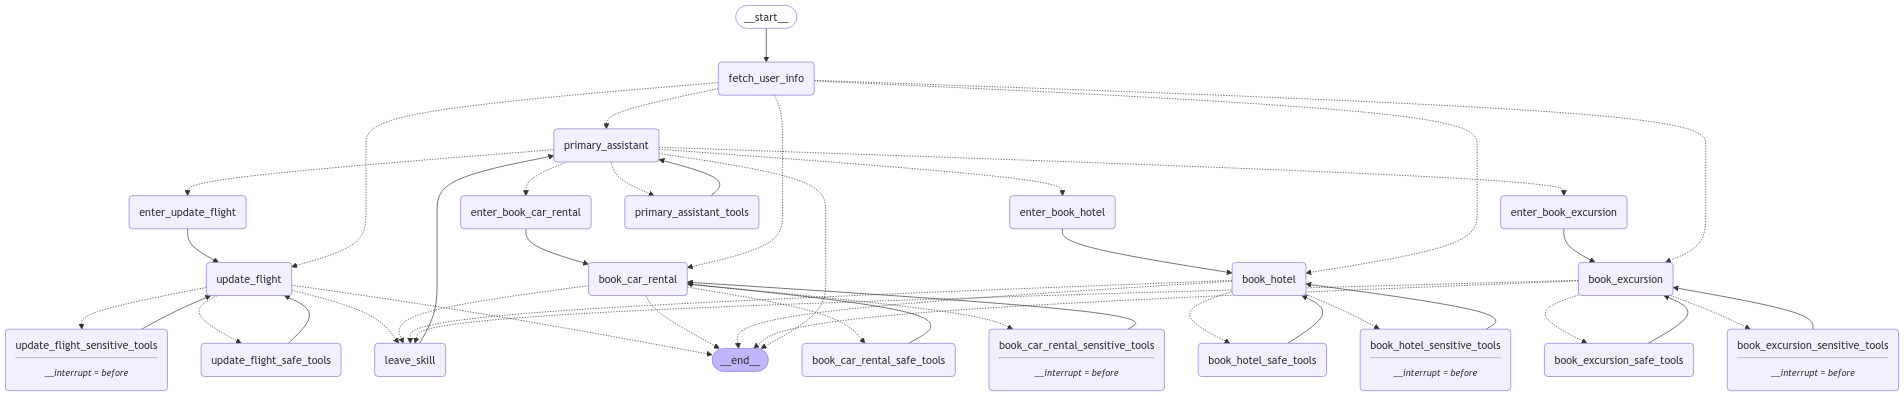

In [30]:
from IPython.display import Image, display

display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))

#### 对话
内容真不少！让我们通过以下一系列对话轮次来运行它。这次，我们将大幅减少确认环节。

In [19]:
import shutil
import uuid
import sys
# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}
# tutorial_questions = [
#     "Hi there, what time is my flight?",
#     "Am i allowed to update my flight to something sooner? I want to leave later today.",
#     "Update my flight to sometime next week then",
#     "The next available option is great",
#     "what about lodging and transportation?",
#     "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
#     "OK could you place a reservation for your recommended hotel? It sounds nice.",
#     "yes go ahead and book anything that's moderate expense and has availability.",
#     "Now for a car, what are my options?",
#     "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
#     "Cool so now what recommendations do you have on excursions?",
#     "Are they available while I'm there?",
#     "interesting - i like the museums, what options are there? ",
#     "OK great pick one and book it for my second day there.",
# ]
_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
# for question in tutorial_questions:
while True:
    question = input("user:")
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
        sys.stdout.flush()
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_4_graph.invoke(
                None,
                config,
            )
            print("y")
            print("="*35, "messages", "="*35)
            for i in result["messages"]:
                print(type(i), i)
            sys.stdout.flush()
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

Your flight, LX0112, is scheduled to depart at 14:14 today, from Charles de Gaulle Airport (CDG) and arrive at EuroAirport Basel–Mulhouse–Freiburg (BSL) at 15:44. Please make sure you're at the gate on time.
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_76225f10b3c84043832ccc)
 Call ID: call_76225f10b3c84043832ccc
  Args:
    query: Can a passenger update their flight to a later time on the same day?
================================= Tool Message =================================
Name: lookup_policy


## Booking and Cancellation

1. How can I change my booking?


KeyboardInterrupt: 

#### 结论
现在，您已经开发了一个客户支持机器人，它能够通过聚焦的工作流程处理各种任务。更重要的是，您已经学会了使用LangGraph的一些核心功能，根据产品需求设计和重构应用程序。

上述示例绝不是针对您的独特需求进行优化的——LLMs可能会出错，每个流程都可以通过更好的提示和实验变得更加可靠。一旦您创建了初始的支持机器人，下一步就是开始添加评估，以便您可以自信地改进系统。查看这些文档和我们的其他教程，以了解更多信息！